#### Tree on windows
 find . -type d \ 
  -not -path "*/.git*" \
  -not -path "*/.venv*" \
  -not -path "*/__pycache__*" \
  -not -path "*/distutils_hack*" \
  | sed -e 's;[^/]*/;|____;g;s;____|; |;g'

### Need to fix a relative path

In [16]:
import pandas as pd 

df = pd.read_csv(r"C:\Taxi-Prediction\Taxi_prediction\src\taxipred\data\taxi_trip_pricing.csv")
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [17]:
df.shape


(1000, 11)

In [18]:
df.columns

Index(['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
       'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price'],
      dtype='object')

In [19]:
df.dtypes

Trip_Distance_km         float64
Time_of_Day               object
Day_of_Week               object
Passenger_Count          float64
Traffic_Conditions        object
Weather                   object
Base_Fare                float64
Per_Km_Rate              float64
Per_Minute_Rate          float64
Trip_Duration_Minutes    float64
Trip_Price               float64
dtype: object

#### Histogram

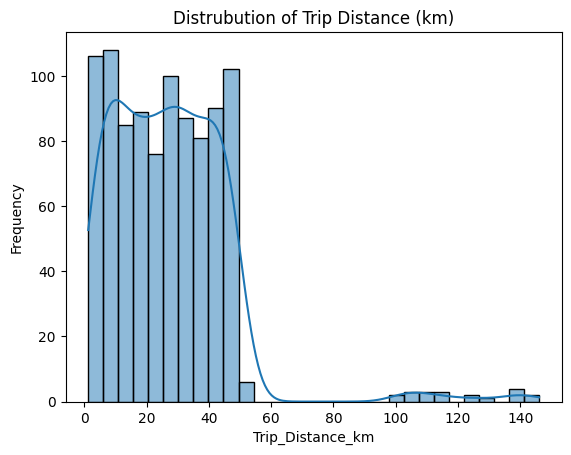

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['Trip_Distance_km'], bins=30, kde=True)
plt.title('Distrubution of Trip Distance (km)')
plt.xlabel('Trip_Distance_km')
plt.ylabel('Frequency')
plt.show()

#### Scatterplot

<Axes: xlabel='Trip_Distance_km', ylabel='Trip_Price'>

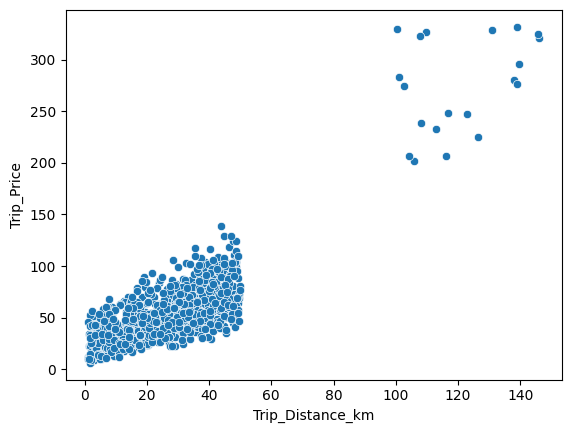

In [34]:
sns.scatterplot(x='Trip_Distance_km', y='Trip_Price', data=df)


## bar

<Axes: xlabel='Time_of_Day'>

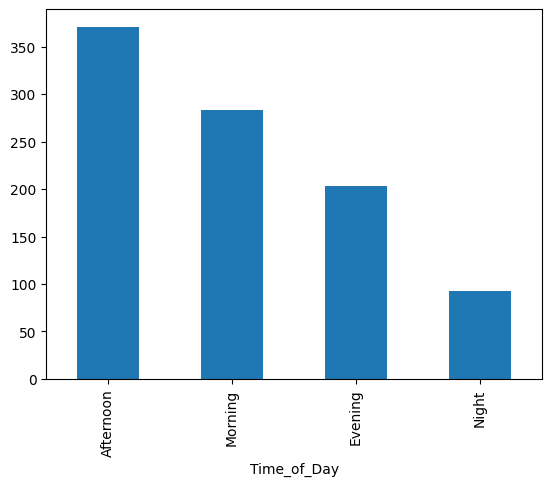

In [27]:
df['Time_of_Day'].value_counts().plot(kind='bar')

### Heatmap

<Axes: >

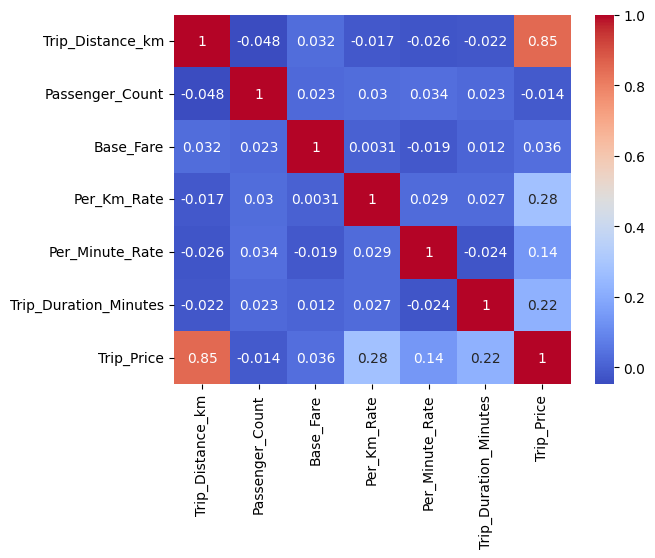

In [29]:
numeric_df = df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')

### Boxplot

<Axes: xlabel='Time_of_Day', ylabel='Trip_Price'>

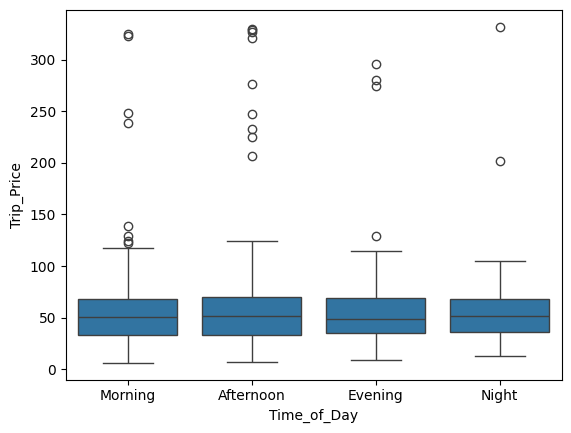

In [30]:
sns.boxplot(x='Time_of_Day', y='Trip_Price', data=df)

#### Another boxplot but with 1 different column, compared to the previous one

<Axes: xlabel='Day_of_Week', ylabel='Trip_Price'>

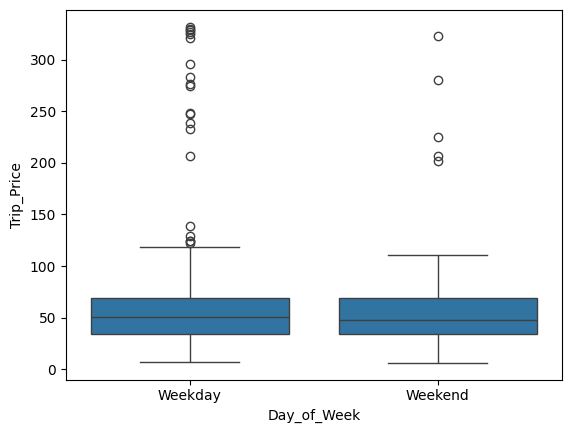

In [36]:
sns.boxplot(x='Day_of_Week', y='Trip_Price', data=df)

#### Crosstab

<Axes: xlabel='Traffic_Conditions'>

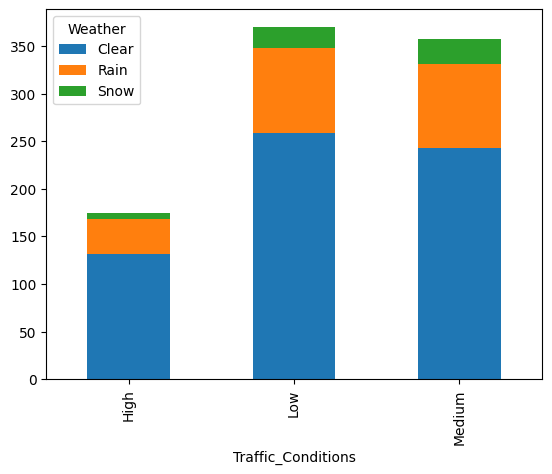

In [37]:
pd.crosstab(df['Traffic_Conditions'], df['Weather']).plot(kind='bar', stacked=True)

#### What period of the day/weekday is traveling with taxi most expensive?

#### Average trip price by Time of the day

In [53]:
df.groupby('Time_of_Day')['Trip_Price'].mean().sort_values(ascending=False)

Time_of_Day
Afternoon    57.958716
Evening      56.404504
Night        56.304401
Morning      55.949429
Name: Trip_Price, dtype: float64

#### Average trip price by Day of the week

In [54]:
df.groupby('Day_of_Week')['Trip_Price'].mean().sort_values(ascending=False)

Day_of_Week
Weekday    58.012418
Weekend    55.001961
Name: Trip_Price, dtype: float64

#### Both measurements combined for a heatmap/visualisation

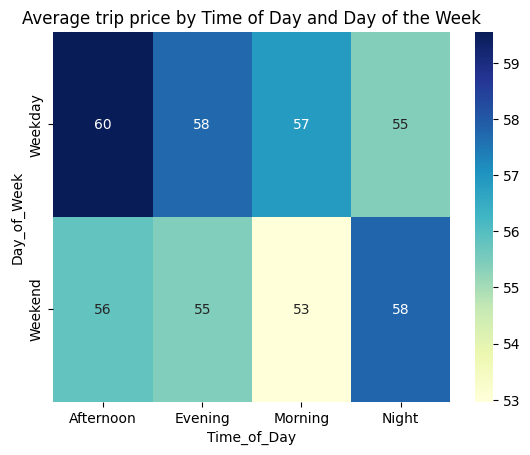

In [55]:
pivot = df.pivot_table(values='Trip_Price', index='Day_of_Week', columns='Time_of_Day', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Average trip price by Time of Day and Day of the Week')
plt.show()


#### Measuring null values

In [40]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

In [41]:
(df.isnull().sum() / len(df)) * 100

Trip_Distance_km         5.0
Time_of_Day              5.0
Day_of_Week              5.0
Passenger_Count          5.0
Traffic_Conditions       5.0
Weather                  5.0
Base_Fare                5.0
Per_Km_Rate              5.0
Per_Minute_Rate          5.0
Trip_Duration_Minutes    5.0
Trip_Price               4.9
dtype: float64

In [44]:
df_price_missing = df[df['Trip_Price'].isnull()]

In [45]:
df_cleaned = df.dropna(subset=[col for col in df.columns if col != 'Trip_Price'])

##### Created a safe copy and filled missing values in Passenger_count and Weather

In [47]:
df_cleaned = df_cleaned.copy()

df_cleaned['Passenger_Count'] = df_cleaned['Passenger_Count'].fillna(0)
df_cleaned['Weather'] = df_cleaned['Weather'].fillna(df_cleaned['Weather'].mode()[0])

##### Identify extreme values

<Axes: xlabel='Trip_Price'>

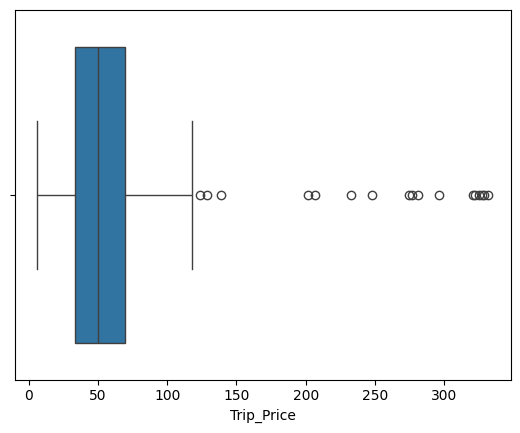

In [48]:
sns.boxplot(x=df_cleaned['Trip_Price'])

#### Remove outliers with IQR-Method

In [49]:
Q1 = df_cleaned['Trip_Price'].quantile(0.25)
Q3 = df_cleaned['Trip_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_cleaned[(df_cleaned['Trip_Price'] >= lower_bound) & (df_cleaned['Trip_Price'] <= upper_bound)] 

#### Boxplot of Trip_Price after cleaning data using IQR method

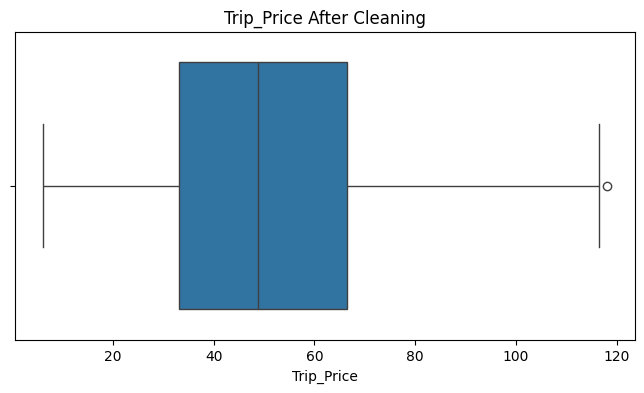

In [51]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.boxplot(x=df_cleaned['Trip_Price'])
plt.title('Trip_Price After Cleaning')
plt.show()

#### Exporting the cleaned data

In [50]:
df_cleaned.to_csv('cleaned_data.csv', index=False)
df_price_missing.to_csv('prediction_input.csv', index=False)

### Visuals

<Axes: >

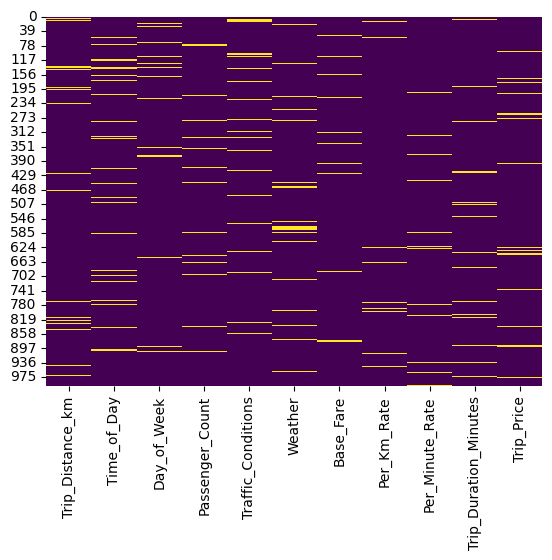

In [39]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

#### For ml

In [32]:
df_encoded = pd.get_dummies(df, columns=['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather'], drop_first=True)

In [38]:
df['Time_of_Day'].head()

0      Morning
1    Afternoon
2      Evening
3      Evening
4      Evening
Name: Time_of_Day, dtype: object